# 1-layer nengo wave 


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist, squareform
%matplotlib inline
from IPython.display import clear_output


import nengo
from nengo.params import Parameter, NumberParam, NdarrayParam
from nengo.neurons import settled_firingrate

def adjacency(num, ri, ro, sqR):
    """Calculate intra-layer adjacency matrix encoding the spacial connectivity 
    of neurons within the layer.

    Parameters
    ----------
    num : int
        Number of neurons in layer
    ri : float
        Excitation radius
    ro : float
        Inhibition radius
    sqR : int
    """
    
    nx = sqR*np.random.rand(num,2)
    D = squareform(pdist(nx))
    S = np.zeros((num, num))
    
    for index, x in np.ndenumerate(D):
        if (x < ri):
            S[index] = 30
        elif (x > ro):
            S[index] = -10*math.exp(-x / 10)        
    S = S - np.diag(np.diag(S)) 
    return nx, S

class CustomLIF(nengo.neurons.NeuronType):
    """Spiking version of the leaky integrate-and-fire (LIF) neuron model.

    Parameters
    ----------
    tau_rc : float
        Membrane RC time constant, in seconds. Affects how quickly the membrane
        voltage decays to zero in the absence of input (larger = slower decay).
    tau_ref : float
        Absolute refractory period, in seconds. This is how long the
        membrane voltage is held at zero after a spike.
    min_voltage : float
        Minimum value for the membrane voltage. If ``-np.inf``, the voltage
        is never clipped.
    amplitude : float
        Scaling factor on the neuron output. Corresponds to the relative
        amplitude of the output spikes of the neuron.
    num : int
        Number of neurons in the layer.
    S : ndarray
        Intra-layer adjacency matrix.
    """

    probeable = ("spikes", "voltage", "refractory_time", "threshold")

    min_voltage = NumberParam("min_voltage", high=0)
    tau_rc = NumberParam("tau_rc", low=0, low_open=True)
    tau_ref = NumberParam("tau_ref", low=0)
    amplitude = NumberParam("amplitude", low=0, low_open=True)
    num = NumberParam("num")
    S = NdarrayParam("S")  # adjacency matrix
    tau_th = NumberParam("tau_th")
    th_plus = NumberParam("th_plus")
    v_th = NumberParam("v_th")
    v_reset = NdarrayParam("v_reset")  # noise on activity field
    
    def __init__(
        self, 
        S, 
        num, 
        tau_rc, 
        tau_th,
        th_plus,
        v_th,
        v_reset,
        nx,
        tau_ref=0.002, 
        min_voltage=0, 
        amplitude=1,
        counter = 0
    ):
        super().__init__() # inherits properties and methods from NeuronType class
        # additional properties
        self.tau_rc = tau_rc
        self.tau_ref = tau_ref
        self.amplitude = amplitude
        self.min_voltage = min_voltage
        self.num = num
        self.S = S
        self.tau_th=tau_th
        self.th_plus=th_plus
        self.v_th=v_th
        self.v_reset=v_reset
        self.nx = nx
        self.counter = counter

    def gain_bias(self, max_rates, intercepts):
        """Analytically determine gain, bias."""
#         max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
#         intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)

#         inv_tau_ref = 1.0 / self.tau_ref if self.tau_ref > 0 else np.inf
#         if np.any(max_rates > inv_tau_ref):
#             raise ValidationError(
#                 "Max rates must be below the inverse "
#                 "refractory period (%0.3f)" % inv_tau_ref,
#                 attr="max_rates",
#                 obj=self,
#             )

#         x = 1.0 / (1 - np.exp((self.tau_ref - (1.0 / max_rates)) / self.tau_rc))
#         gain = (1 - x) / (intercepts - 1.0)
#         bias = 1 - gain * intercepts
        gain = np.ones((self.num,))
        bias = np.zeros((self.num,))
        return gain, bias
    

    def max_rates_intercepts(self, gain, bias):
        """Compute the inverse of gain_bias."""
        intercepts = (1 - bias) / gain
        max_rates = 1.0 / (
            self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))
        )
        if not np.all(np.isfinite(max_rates)):
            warnings.warn(
                "Non-finite values detected in `max_rates`; this "
                "probably means that `gain` was too small."
            )
        return max_rates, intercepts


    def rates(self, x, gain, bias):
        """Always use LIFRate to determine rates."""
        J = self.current(x, gain, bias)
        out = np.zeros_like(J)
        # Use LIFRate's step_math explicitly to ensure rate approximation
        LIFRate.step_math(self, dt=1, J=J, output=out)
        return out


    def step_math(self, dt, J, spiked, voltage, refractory_time, threshold):        
#         print('init voltage = {}'.format(voltage))
        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        # delta_t = (dt - refractory_time).clip(0, dt)
        
        # step voltage
#         print('spiked = {}'.format(spiked.shape))
#         print('S = {}'.format(S.shape))
        
        U = np.matmul(spiked, S)
#         print('U = {}'.format(U))
        eta = 3*np.random.rand(self.num,)
#         print('eta = {}'.format(eta))
        dV = (1/self.tau_rc) * (-1*voltage + U + eta)
#         print('dV = {}'.format(dV))
        voltage[:] += dV * dt
#         print('final voltage = {}'.format(voltage))

        
        # step threshold voltage (theta)
        # How to have threshold initially ones?
        dTh = (1/self.tau_th)*(self.v_th-threshold)*(1-spiked)+self.th_plus*spiked
        threshold[:] += dTh * dt
#         print('threshold = {}'.format(threshold))
        
        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > threshold
        spiked[:] = spiked_mask * (self.amplitude)
#         print('spiked = {}'.format(spiked))
#         print('______________')
#         print(nx[spiked_mask])


        self.counter += 1
        
        plt.scatter(nx[:,0], nx[:,1])
        plt.scatter(nx[spiked_mask, 0], nx[spiked_mask, 1], color = 'r')
        plt.title("Ret-Wave: step=" + str(self.counter))
        plt.show()
        clear_output(wait=True)
        
#         print('______________')
#         # set v(0) = 1 and solve for t to compute the spike time
#         t_spike = dt + self.tau_rc * np.log1p(
#             -(voltage[spiked_mask] - 1) / (J[spiked_mask] - 1)
#         )

        # set spiked voltages to v_reset, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < self.min_voltage] = self.min_voltage 
        voltage[spiked_mask] = self.v_reset[spiked_mask]
        refractory_time[spiked_mask] = self.tau_ref #+ t_spike

In [6]:
from nengo.builder.operator import Operator

class SimCustomLIF(Operator):
    """Set a neuron model output for the given input current.

    Implements ``neurons.step_math(dt, J, output, *states)``.

    Parameters
    ----------
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    J : Signal
        The input current.
    output : Signal
        The neuron output signal that will be set.
    states : list, optional
        A list of additional neuron state signals set by ``step_math``.
    tag : str, optional
        A label associated with the operator, for debugging purposes.

    Attributes
    ----------
    J : Signal
        The input current.
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    output : Signal
        The neuron output signal that will be set.
    states : list
        A list of additional neuron state signals set by ``step_math``.
    tag : str or None
        A label associated with the operator, for debugging purposes.

    Notes
    -----
    1. sets ``[output] + states``
    2. incs ``[]``
    3. reads ``[J]``
    4. updates ``[]``
    """
    
    def __init__(self, neurons, J, output, states=None, tag=None):
        super().__init__(tag=tag)
        self.neurons = neurons

        self.sets = [output] + ([] if states is None else states)
        self.incs = []
        self.reads = [J]
        self.updates = []

    @property
    def J(self):
        return self.reads[0]

    @property
    def output(self):
        return self.sets[0]

    @property
    def states(self):
        return self.sets[1:]

    def _descstr(self):
        return "%s, %s, %s" % (self.neurons, self.J, self.output)

    def make_step(self, signals, dt, rng):
        J = signals[self.J]
        output = signals[self.output]
        states = [signals[state] for state in self.states]

        def step_simcustomlif():
            self.neurons.step_math(dt, J, output, *states)

        return step_simcustomlif

In [7]:
from nengo.builder import Builder
from nengo.builder.operator import Copy
from nengo.builder.signal import Signal
from nengo.rc import rc


@Builder.register(CustomLIF)
def build_customlif(model, neuron_type, neurons):
    """Builds a `.LIF` object into a model.

    In addition to adding a `.SimNeurons` operator, this build function sets up
    signals to track the voltage and refractory times for each neuron.

    Parameters
    ----------
    model : Model
        The model to build into.
    neuron_type : CustomLIF
        Neuron type to build.
    neuron : Neurons
        The neuron population object corresponding to the neuron type.

    Notes
    -----
    Does not modify ``model.params[]`` and can therefore be called
    more than once with the same `.LIF` instance.
    """

    model.sig[neurons]["voltage"] = Signal(
        shape=neurons.size_in, name="%s.voltage" % neurons
    )
    model.sig[neurons]["refractory_time"] = Signal(
        shape=neurons.size_in, name="%s.refractory_time" % neurons
    )
    model.sig[neurons]["threshold"] = Signal(
        shape=neurons.size_in, name= "%s.threshold" % neurons
    )
    model.add_op(
        SimCustomLIF(
            neurons=neuron_type,
            J=model.sig[neurons]["in"],
            output=model.sig[neurons]["out"],
            states=[
                model.sig[neurons]["voltage"],
                model.sig[neurons]["refractory_time"],
                model.sig[neurons]["threshold"],
            ],
        )
    )

Text(0, 0.5, 'Neuron number')

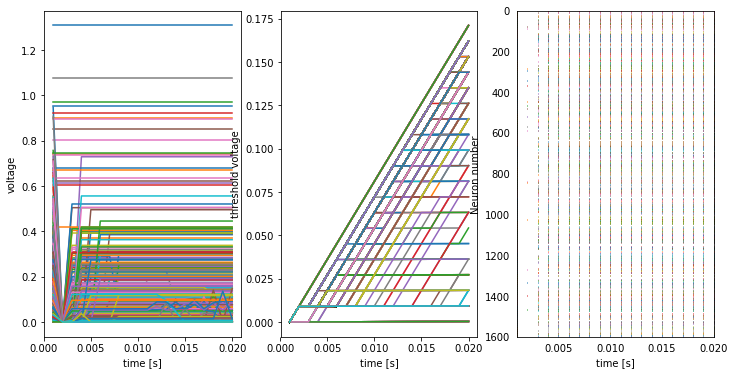

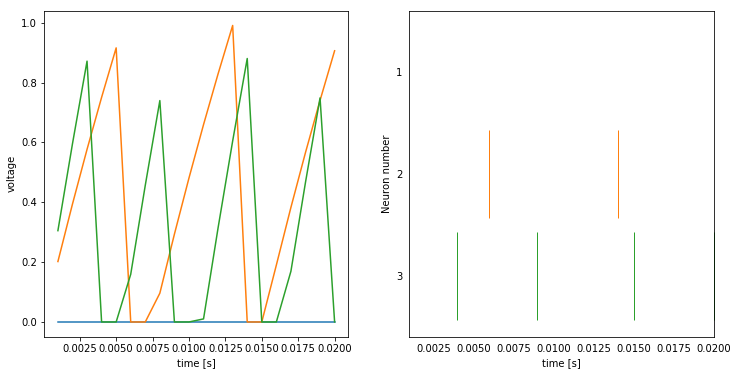

In [17]:
from nengo.utils.matplotlib import rasterplot
# import nengo_loihi

num = 1600

nx, S = adjacency(num, 3, 6, 28)
print('S = {}'.format(S))
rand = np.random.randn(num,)
v_reset = 0+0.1*rand*rand

# nengo_loihi.set_defaults()

# save matrix of neuron position
# store cell matrix of varying lengths for firedMat. calculate number of time steps, 100 neurons, use number of time steps to initialize
# play around with radii


model = nengo.Network(label='2D Representation', seed=10)
# process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, .01), seed=1)
# took out noise = process in both ensembles, still fine

with model:
    a = nengo.Ensemble(num, dimensions=2, neuron_type=CustomLIF(S, num, 2, 60, 9, 1, v_reset, nx))
    b = nengo.Ensemble(3, dimensions=2, neuron_type=nengo.LIF())
    spikes_probe = nengo.Probe(a.neurons, 'spikes')
    voltage_probe = nengo.Probe(a.neurons, 'voltage')
    threshold_probe = nengo.Probe(a.neurons, 'threshold')
    b_spikes = nengo.Probe(b.neurons, 'spikes')
    b_voltage = nengo.Probe(b.neurons, 'voltage')
with nengo.Simulator(model) as sim:
    sim.run(.02)
    
# Custom LIF neurons
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(sim.trange(), sim.data[voltage_probe], label="voltage")
plt.xlabel('time [s]')
plt.ylabel('voltage')
# plt.legend(loc=4);

plt.subplot(132)
plt.plot(sim.trange(), sim.data[threshold_probe], label="threshold")
plt.xlabel('time [s]')
plt.ylabel('threshold voltage')
# plt.legend(loc=4);

plt.subplot(133)
rasterplot(sim.trange(), sim.data[spikes_probe])
plt.xlabel('time [s]')
plt.ylabel('Neuron number')

# Compare to Nengo's LIF neurons
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(sim.trange(), sim.data[b_voltage], label="voltage")
plt.xlabel('time [s]')
plt.ylabel('voltage')
# plt.legend(loc=4);

plt.subplot(122)
rasterplot(sim.trange(), sim.data[b_spikes])
plt.xlabel('time [s]')
plt.ylabel('Neuron number')